## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2021.

# Assignment 1, Task 3: Multilayer Perceptron (MLP)
This is the third part of the assignment. You will get to implement MLP using tensorflow

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.datasets import fashion_mnist

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
# Load the raw Fashion-MNIST data.
train, test = fashion_mnist.load_data()

X_train_raw, y_train = train
X_test_raw, y_test = test

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 784) (1000, 784) (10000, 784) (100, 784)
Train data shape:  (49000, 784)
Train labels shape:  (49000,)
Validation data shape:  (1000, 784)
Validation labels shape:  (1000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


## Part 1: Tensorflow MLP
In this part, you will use tensorflow modules to implement a MLP. We provide a demo of a two-layer net, of which style is referred to https://www.tensorflow.org/guide/keras, and https://www.tensorflow.org/guide/eager. 

You need to implement a multi-layer with 3 layers in a similar style.

### Demo: Two-layer MLP in Tensorflow

In [3]:
## Demo: Two-layer net in tensorflow (eager execution mode)
hidden_dim = 300
reg_tf = tf.constant(0.01)

# define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W1 = tf.Variable(1e-2*np.random.rand(X_train.shape[1], hidden_dim).astype('float32'))
        self.b1 = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
        self.W2 = tf.Variable(1e-2*np.random.rand(hidden_dim, 20).astype('float32'))
        self.b2 = tf.Variable(np.zeros((20,)).astype('float32'))
    def call(self, inputs):
        """Run the model."""
        h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
        out = tf.matmul(h1, self.W2) + self.b2
        return out

# Define and calculate loss function (Note that in eager execution, loss must be in a function)
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
    L2_loss = tf.nn.l2_loss(model.W1) + tf.nn.l2_loss(model.W2)
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    return tape.gradient(loss_value, [model.W1, model.b1, model.W2, model.b2])

# calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 12
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        #optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads, [model.W1, model.b1, model.W2, model.b2]))

    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.7509999871253967
epoch 2: valid acc = 0.7910000085830688
epoch 3: valid acc = 0.8119999766349792
epoch 4: valid acc = 0.8270000219345093
epoch 5: valid acc = 0.8389999866485596
epoch 6: valid acc = 0.8460000157356262
epoch 7: valid acc = 0.859000027179718
epoch 8: valid acc = 0.859000027179718
epoch 9: valid acc = 0.8610000014305115
epoch 10: valid acc = 0.8650000095367432
epoch 11: valid acc = 0.8690000176429749
epoch 12: valid acc = 0.871999979019165
test acc = 0.8572999835014343


### Create Deeper Network

<span style="color:red"><strong>TODO</strong></span>: Create your MLP in tensorflow. Since you are going to create a deeper neural network, it is recommended to use "list" to store your network parameters (weights and bias). Consider using a loop to create your MLP network. Hint: Copy the above code and make necessary changes in model definition.

<span style="color:red"><strong>Solution</strong></span>:

In [4]:
## Demo: Two-layer net in tensorflow (eager execution mode)
hidden_dim = 300
reg_tf = tf.constant(0.01)

# define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W1 = tf.Variable(1e-2*np.random.rand(X_train.shape[1], hidden_dim).astype('float32'))
        self.b1 = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
        self.W2 = tf.Variable(1e-2*np.random.rand(hidden_dim, 20).astype('float32'))
        self.b2 = tf.Variable(np.zeros((20,)).astype('float32'))
    def call(self, inputs):
        """Run the model."""
        h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
        out = tf.matmul(h1, self.W2) + self.b2
        return out

# Define and calculate loss function (Note that in eager execution, loss must be in a function)
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
    L2_loss = tf.nn.l2_loss(model.W1) + tf.nn.l2_loss(model.W2)
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    return tape.gradient(loss_value, [model.W1, model.b1, model.W2, model.b2])

# calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 12
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        #optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads, [model.W1, model.b1, model.W2, model.b2]))

    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.7440000176429749
epoch 2: valid acc = 0.7749999761581421
epoch 3: valid acc = 0.8220000267028809
epoch 4: valid acc = 0.8379999995231628
epoch 5: valid acc = 0.8489999771118164
epoch 6: valid acc = 0.8560000061988831
epoch 7: valid acc = 0.8550000190734863
epoch 8: valid acc = 0.8579999804496765
epoch 9: valid acc = 0.8579999804496765
epoch 10: valid acc = 0.8640000224113464
epoch 11: valid acc = 0.8659999966621399
epoch 12: valid acc = 0.8679999709129333
test acc = 0.8567000031471252


### Introduction to TensorFlow.keras

As you can see, when the network structure becomes larger, it is hard to handle variables from every layer. Here we introduce the `tf.keras` tool to build the network in a much simpler way. You may want to use it in your project.

<span style="color:red"><strong>TODO</strong></span>: Follow this official example: https://www.tensorflow.org/datasets/keras_example#step_2_create_and_train_the_model to build an MLP and train it. 

*You should keep the same optimizer (SGD) and loss function (cross entropy) as in the previous task.*

**Note:** Since we want to use our own dataset, we will not use the `tfds.load` method to load the data this time. 

You need to check the usage of [`model.fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) and feed the model with our own data.

**Tips:**
* Softmax is also registered as a layer operation in tf.keras.
* You can use `model.summary()` to visualize the model after you build it.
* Use `verbose=2` in `model.fit()` to get similar training logs

<span style="color:red"><strong>SOLUTION</strong></span>:

In [5]:
#############################################################
# TODO: build the model with tf.keras.models.Sequential

# END of your code
#############################################################

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(200,activation='relu'),
    tf.keras.layers.Dense(10)
])

#############################################################
# TODO: compile the model, set optimizer and loss

# END of your code
#############################################################

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

#############################################################
# TODO: train the model with our own dataset

# END of your code
#############################################################

model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_test, y_test)
)

Epoch 1/20
1532/1532 [==============================] - 5s 3ms/step - loss: 18.6691 - sparse_categorical_accuracy: 0.7628 - val_loss: 5.8180 - val_sparse_categorical_accuracy: 0.8141
Epoch 2/20
1532/1532 [==============================] - 4s 3ms/step - loss: 4.2323 - sparse_categorical_accuracy: 0.8332 - val_loss: 3.8512 - val_sparse_categorical_accuracy: 0.7832
Epoch 3/20
1532/1532 [==============================] - 4s 3ms/step - loss: 2.2972 - sparse_categorical_accuracy: 0.8349 - val_loss: 2.6280 - val_sparse_categorical_accuracy: 0.8119
Epoch 4/20
1532/1532 [==============================] - 4s 3ms/step - loss: 2.0059 - sparse_categorical_accuracy: 0.8354 - val_loss: 2.3312 - val_sparse_categorical_accuracy: 0.8261
Epoch 5/20
1532/1532 [==============================] - 5s 3ms/step - loss: 1.9416 - sparse_categorical_accuracy: 0.8354 - val_loss: 2.6541 - val_sparse_categorical_accuracy: 0.8338
Epoch 6/20
1532/1532 [==============================] - 4s 3ms/step - loss: 2.0562 - spar

## Part 2: t-SNE (optional, bonus +5 points)

t-SNE is is a machine learning algorithm for nonlinear dimensionality reduction developed by Geoffrey Hinton and Laurens van der Maaten. It is also a good way of visualizing high-dimensional data in 2D. We show its application for CIFAR100. Later it will be re-used in a CNN network. Experimenting with t-SNE can be fun. One thing to try is to visualize the output of each layer of MLP to observe the differences.

<p style="line-height: 1.2;">[1] Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of Machine Learning Research 9.Nov (2008): 2579-2605.</p>
<p style="line-height: 1.2;">[2] Adaptive learning rate scheme by Jacobs https://www.willamette.edu/~gorr/classes/cs449/Momentum/deltabardelta.html</p>
<p style="line-height: 1.2;">[3] http://cs.stanford.edu/people/karpathy/cnnembed/</p>
<p style="line-height: 1.2;">[4] How to Use t-SNE Effectively, with examples.
 https://distill.pub/2016/misread-tsne</p>

In [6]:
from utils.train_funcs import train, test
from utils.classifiers.mlp import MLP
from utils.features.tsne import tsne

In [7]:
# Load the raw Fashion-MNIST data.
train_data, test_data = fashion_mnist.load_data()

X_train_raw, y_train = train_data
X_test_raw, y_test = test_data

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 784) (1000, 784) (10000, 784) (100, 784)
Train data shape:  (49000, 784)
Train labels shape:  (49000,)
Validation data shape:  (1000, 784)
Validation labels shape:  (1000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


#### tSNE of original data

In [8]:
random_select = np.random.choice(10000, 500, replace=False)
X = X_test_raw[random_select,:,:].reshape(500,X_train.shape[1]).astype('float')/255.0
tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)
print("it takes {} seconds".format(time.time()-tic))

2.8980443078634526
The 100 th loop cost: 11.513509843096012, computation time: 2.3848888874053955
The 200 th loop cost: 0.54021817875394, computation time: 4.758866786956787
The 300 th loop cost: 0.5081392682526845, computation time: 7.134639501571655
The 400 th loop cost: 0.5026333643276144, computation time: 9.502594709396362
The 500 th loop cost: 0.5014264711417742, computation time: 11.863599300384521
The 600 th loop cost: 0.5009880946612876, computation time: 14.253322839736938
The 700 th loop cost: 0.5007896613850725, computation time: 16.626214504241943
The 800 th loop cost: 0.5006893120622249, computation time: 19.005863904953003
The 900 th loop cost: 0.5006345704592959, computation time: 21.39568018913269
The 1000 th loop cost: 0.500603276211438, computation time: 23.778338193893433
it takes 24.72869563102722 seconds


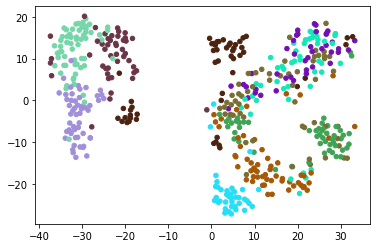

In [9]:
## visualize tSNE of original data
labels = y_test[random_select]
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#### tSNE of data after two hidden layers

Do visualization of the tSNE of data after going through MLP. In the visualization result, you should find that in comparison with the tSNE of original data where all data points mess up with each other, tSNE of data after two-layer networks would be shown as multiple clusters in a 2D panel.

In [10]:
# Define MLP model
model = MLP(input_dim=X_train.shape[1], hidden_dims=[100], num_classes=20, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 200
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 245
epoch 1: valid acc = 0.816, new learning rate = 0.00095
epoch 2: valid acc = 0.85, new learning rate = 0.0009025
epoch 3: valid acc = 0.863, new learning rate = 0.000857375
epoch 4: valid acc = 0.874, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.869, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.877, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.874, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.877, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.882, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.881, new learning rate = 0.0005987369392383785
test acc: 0.8677


0.8677

<span style="color:red"><strong>TODO</strong></span>: Visualize data that is passed through MLP model defined above using tSNE. 

In [11]:
# run tSNE
X = X_test[random_select]
tic = time.time()

#############################################################################
#                          START OF YOUR CODE                               #
# Hint: Pass data through affine and dense layers (model.layers) and then 
# apply softmax to obtain output of the MLP model.
#############################################################################

for layer in model.layers:
    X = layer.feedforward(X)
softmax = np.exp(X - np.max(X, axis=1, keepdims=True))
softmax /= np.sum(softmax, axis=1, keepdims=True)

y_pred = tsne(softmax, low_dim=2, perplexity=30.0)

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

0.1224608553601534
The 100 th loop cost: 8.239171711686835, computation time: 2.3858847618103027
The 200 th loop cost: 0.2179418653266453, computation time: 4.78331732749939
The 300 th loop cost: 0.18972924711915135, computation time: 7.179180145263672
The 400 th loop cost: 0.18133738847515074, computation time: 9.576595067977905
The 500 th loop cost: 0.1779334674274214, computation time: 11.940328598022461
The 600 th loop cost: 0.176060776812183, computation time: 14.316312313079834
The 700 th loop cost: 0.17485501826440236, computation time: 16.69900631904602
The 800 th loop cost: 0.1739998873688248, computation time: 19.09778380393982
The 900 th loop cost: 0.17334739032160837, computation time: 21.494178295135498
The 1000 th loop cost: 0.17284321041665385, computation time: 23.8910129070282
it takes 24.891277313232422 seconds


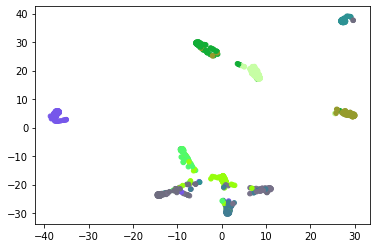

In [12]:
# visualize tSNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
# Hint: See tSNE visualization of original data
#############################################################################

labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(y_pred[:,0], y_pred[:,1], 20, color_labels)
plt.show()

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

<span style="color:red"><strong>TODO</strong></span>: Try tuning the parameters of tSNE, do visualization of the new tSNE of data.

In [13]:
# Tune the parameter, show the results.
# run tSNE
X = X_test[random_select]

#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################

for layer in model.layers:
    X = layer.feedforward(X)
softmax = np.exp(X - np.max(X, axis=1, keepdims=True))
softmax /= np.sum(softmax, axis=1, keepdims=True)

y_pred = tsne(softmax, low_dim=2, perplexity=40.0)

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

0.23468638566896308
The 100 th loop cost: 7.635854006323696, computation time: 2.410953998565674
The 200 th loop cost: 0.1950616078603455, computation time: 4.835690498352051
The 300 th loop cost: 0.17774132753821706, computation time: 7.2461769580841064
The 400 th loop cost: 0.1726401636306551, computation time: 9.648280620574951
The 500 th loop cost: 0.17042603923851507, computation time: 12.055920839309692
The 600 th loop cost: 0.16890494074571316, computation time: 14.466444969177246
The 700 th loop cost: 0.1678120194141773, computation time: 16.875547647476196
The 800 th loop cost: 0.1671481319721905, computation time: 19.30279016494751
The 900 th loop cost: 0.16671242611765907, computation time: 21.708840370178223
The 1000 th loop cost: 0.1663984181785017, computation time: 24.125508069992065
it takes 50.14643907546997 seconds


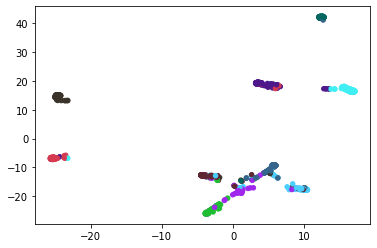

In [14]:
# visualize tSNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################

labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(y_pred[:,0], y_pred[:,1], 20, color_labels)
plt.show()

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################